In [261]:
import os
import importlib
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sbm import SBM
from infect import infect
import algos

importlib.reload(algos)
from algos import binary_splitting, binary_splitting_parallel, diag_splitting, Qtesting1, Qtesting2, Qtesting1_comm_aware, Qtesting2_comm_aware

In [262]:
def connected_components(adj_matrix):
    N = len(adj_matrix)
    visited = [False] * N
    communities = []

    def dfs(node, community):
        stack = [node]
        while stack:
            n = stack.pop()
            if not visited[n]:
                visited[n] = True
                community.append(n)
                neighbors = [i for i, connected in enumerate(adj_matrix[n]) if connected and not visited[i]]
                stack.extend(neighbors)

    for i in range(N):
        if not visited[i]:
            community = []
            dfs(i, community)
            communities.append(community)

    return communities

In [263]:
def iter(N, M, q0, q1, p0, p1, time_steps, num_sims, method, dataset='sbm'):
    
    name = dataset + 'N' + str(N) + '_M' + str(M) + '_SIM' + str(num_sims) + '_step' + str(time_steps) + '_q0' + str(q0) + '_q1' + str(q1) + '_p0' + str(p0) + '_p1' + str(p1) + method + 'graphs.pkl'
    print(name)
    
    if not os.path.isfile(name):
        print('Generating synthetic dataset!')
        Gs = np.zeros((num_sims,N,N))
        Communities = dict()
        data = dict()
        Individuals = dict()
        
        if dataset=='sbm':
            for i in range(num_sims):
                Gs[i] = SBM(N,M,q0,q1)
                ###################################################
                '''your code here'''
                communities = connected_components(Gs[i])
                ###################################################
                Communities[i] = communities
                Individuals[i] = infect(Gs[i], p0, p1, time_steps)
                
        elif dataset=='iid':
            for i in range(num_sims):
                ###################################################
                '''your code here'''
                Gs[i] = np.ones((N, N))
                Individuals[i] = infect(Gs[i], p0, p1, time_steps)
                Communities[i] = [list(range(N))]
                ###################################################
        data['graph'] = Gs
        data['communities'] = Communities
        data['individuals'] = Individuals
        
        with open(name, 'wb') as infile:
            pickle.dump(data,infile) 
        print('Dataset done!')

    ###################################################
    '''your code for initialization parameters if needed''' 
    fraction_ppl = 0
    fraction_family = 0
    fraction_ppl_in_family = 0
    num_tests = {'binary': [], 'binary_parallel': [], 'Q1': [], 'Q2': [], 'Q1_comm': [], 'Q2_comm': []}
    num_stages = {'binary': [], 'binary_parallel': [], 'Q1': [], 'Q2': [], 'Q1_comm': [], 'Q2_comm': []}
    ###################################################
        
    if os.path.isfile(name):
        with open(name, 'rb') as infile:
            data = pickle.load(infile) 
        print('Data loaded!')
        
    for i in range(num_sims):
        
        if dataset=='sbm' or dataset=='iid' or dataset=='synthetic':
            G = data['graph'][i]
            communities = data['communities'][i]
            individuals = data['individuals'][i]
        ###################################################
        '''your code to calculate the statistics here'''
        
        infected_count = np.sum(individuals)
        community_sizes = [len(c) for c in communities]
        
        infected_communities = []
        for c in communities:
            for individual in c:
                if individuals[individual] == 1: 
                    infected_communities.append(c)
                    break
                    
        infected_in_communities = []
        for c in infected_communities:
            num_infected = 0
            
            num_individuals = len(c)
            for i in range(num_individuals):
                if individuals[c[i]] == 1:
                    num_infected += 1
                
            infected_in_communities.append(num_infected)
                
                    
        fraction_ppl += infected_count / N
        fraction_family += len(infected_communities) / len(communities)

        index = 0
        avg_fraction_ppl_in_family = 0
        for c in infected_communities:
            avg_fraction_ppl_in_family += (infected_in_communities[index] / len(c))
            index += 1
            
        avg_fraction_ppl_in_family /= len(communities)
        fraction_ppl_in_family += avg_fraction_ppl_in_family
    
        ###################################################

        # interleave the individuals
        s = individuals.copy()
        np.random.shuffle(s)
        
        # Binary splitting
        numtests_bs, num_stages_bs, _ = binary_splitting(s)
        num_tests['binary'].append(numtests_bs)
        num_stages['binary'].append(num_stages_bs)
        
        # Binary splitting Parallel
        numtests_bs, num_stages_bs, _ = binary_splitting_parallel(s)
        num_tests['binary_parallel'].append(numtests_bs)
        num_stages['binary_parallel'].append(num_stages_bs)
        
        # Qtesting1
        numtests_q1, num_stages_q1, _ = Qtesting1(s)
        num_tests['Q1'].append(numtests_q1)
        num_stages['Q1'].append(num_stages_q1)
        
        # Qtesting2
        numtests_q2, num_stages_q2, _ = Qtesting2(s)
        num_tests['Q2'].append(numtests_q2)
        num_stages['Q2'].append(num_stages_q2)
        
        # Community-aware Qtesting1
        numtests_q1_c, num_stages_q1_c, _ = Qtesting1_comm_aware(individuals.copy(), communities)
        num_tests['Q1_comm'].append(numtests_q1_c)
        num_stages['Q1_comm'].append(num_stages_q1_c)
        
        # Community-aware Qtesting2
        numtests_q2_c, num_stages_q2_c, _ = Qtesting2_comm_aware(individuals.copy(), communities)
        num_tests['Q2_comm'].append(numtests_q2_c)
        num_stages['Q2_comm'].append(num_stages_q2_c)

    ###################################################
    '''your code to calculate the statistics here''' 
    '''Do not forget to take the average'''
    fraction_ppl /= num_sims
    fraction_family /= num_sims
    fraction_ppl_in_family /= num_sims

    avg_num_tests = {k: np.mean(v) for k, v in num_tests.items()}
    avg_num_stages = {k: np.mean(v) for k, v in num_stages.items()}

    ###################################################

    return fraction_ppl, fraction_family, fraction_ppl_in_family, avg_num_tests, avg_num_stages

In [9]:
Gs = []
Gs.append([[0,0,1,0],[0,0,0,0],[1,0,0,0],[0,0,0,0]])
communities = connected_components(Gs[0])
print(communities)

[[0, 2], [1], [3]]


<div class="alert alert-warning">
<b>Task 1 </b> 
Plot how the fraction of infected people, the percentage of infected communities, and the average percentage of infected people in each community change with the each setting for the synthetic dataset described in the following table and comment on the results. Average over at least $100$ SBM network realization.     

</div>

| N | M | q0, q1 | p0 | p1 |time steps  |
|---|---|--------|----|----|------------|
|256| 16| (1,0)  |0.001|[0.05:1]|2|
|   | 16|(0.9, 0.1)  | 0.001| [0.05:1]|2     |
|   | 16 |(0.5, 0.2)  | 0.001| [0.05:1]|2     |

Consider $N=256$, and $M=16,64,128$. Use SBM with $q0=1$ and $q1=0$ to generate contact networks (disconnected cliques). For the infection model, use $p_0 = 0.001$ and $p_1 = [0.01:1]$ and the number of infection steps as $2$ . 
Average over 100 SBM network realizations.

<div class="alert alert-warning">
<b>Task 2 </b> 
Provide plots for i.i.d. infection probability that ranges from $p=0.01$ to $p=0.3$, and $N=256$.
Compare the performance of tests $T_1$, $T_2$, and binary output tests. Do you observe a consistent performance? Can you explain your results? 
    
</div>

<div class="alert alert-warning">
<b>Task 3 </b>  
Provide plots that compare the performance of various testing techniques on the Stochastic Block Model (SBM) using the settings outlined in Table 2 and on real data. You may explore additional settings that could reveal significant insights for your custom algorithms. Interpret and explain the results you obtain. Your plots should include: (i) a plot demonstrating how the performance of different testing schemes varies as the family sizes change, (ii)a plot demonstrating how the performance of different testing schemes varies as the infection probability changes and (iii) a plot illustrating how infections concentrate within families in the SBM.
</div>

| N | M | q0, q1 | p0 | p1 |time steps  |
|---|---|--------|----|----|------------|
|256| 16| (0.9,0.1)  |0.001|[0.05:1]|2|
|   | 64|(1, 0)  | 0.001| [0.05:1]|2     |
|   | 64|(0.9, 0.1)  | 0.001| [0.05:1]|2     |
|   | 64|(0.5, 0.2)  | 0.001| [0.05:1]|2     |
|   | 128 |(0.9, 0.1)  | 0.001| [0.05:1]|2     |


sbmN256_M16_SIM100_step2_q00.9_q10.1_p00.001_p10.05some_methodgraphs.pkl
Generating synthetic dataset!
Dataset done!
Data loaded!
Fraction of people infected: 0.0159765625
Fraction of families with at least one infected: 0.24
Average fraction of people infected in families: 0.0159765625
Average number of tests: {'binary': 33.67, 'binary_parallel': 33.82, 'Q1': 29.34, 'Q2': 29.12, 'Q1_comm': 7.87, 'Q2_comm': 7.76}
Average number of stages: {'binary': 33.67, 'binary_parallel': 3.68, 'Q1': 2.09, 'Q2': 2.23, 'Q1_comm': 2.24, 'Q2_comm': 2.0}
sbmN256_M16_SIM100_step2_q00.9_q10.1_p00.001_p10.15000000000000002some_methodgraphs.pkl
Generating synthetic dataset!
Dataset done!
Data loaded!
Fraction of people infected: 0.07359375
Fraction of families with at least one infected: 0.21
Average fraction of people infected in families: 0.07359375
Average number of tests: {'binary': 150.29, 'binary_parallel': 79.0, 'Q1': 71.97, 'Q2': 60.26, 'Q1_comm': 15.36, 'Q2_comm': 15.63}
Average number of stages: {

<Figure size 3600x1800 with 0 Axes>

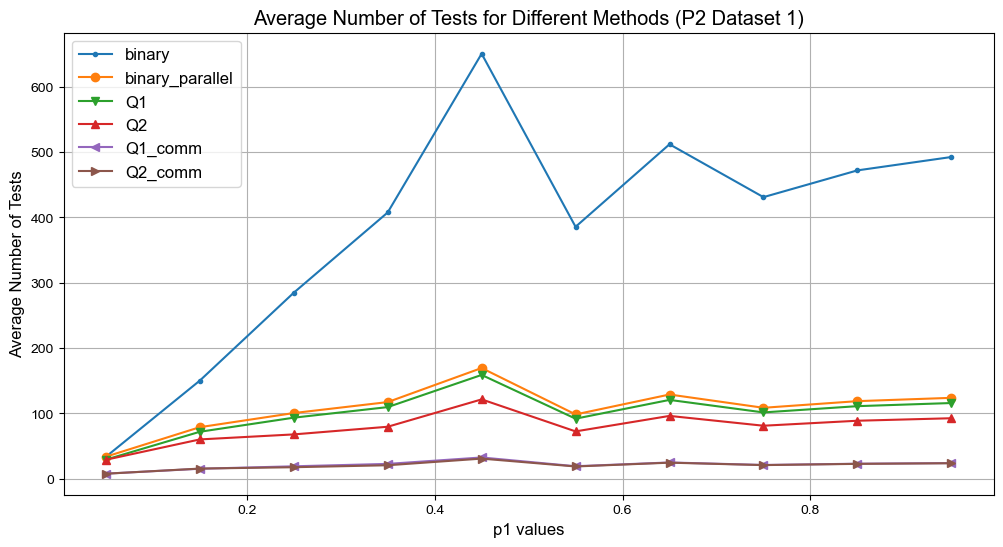

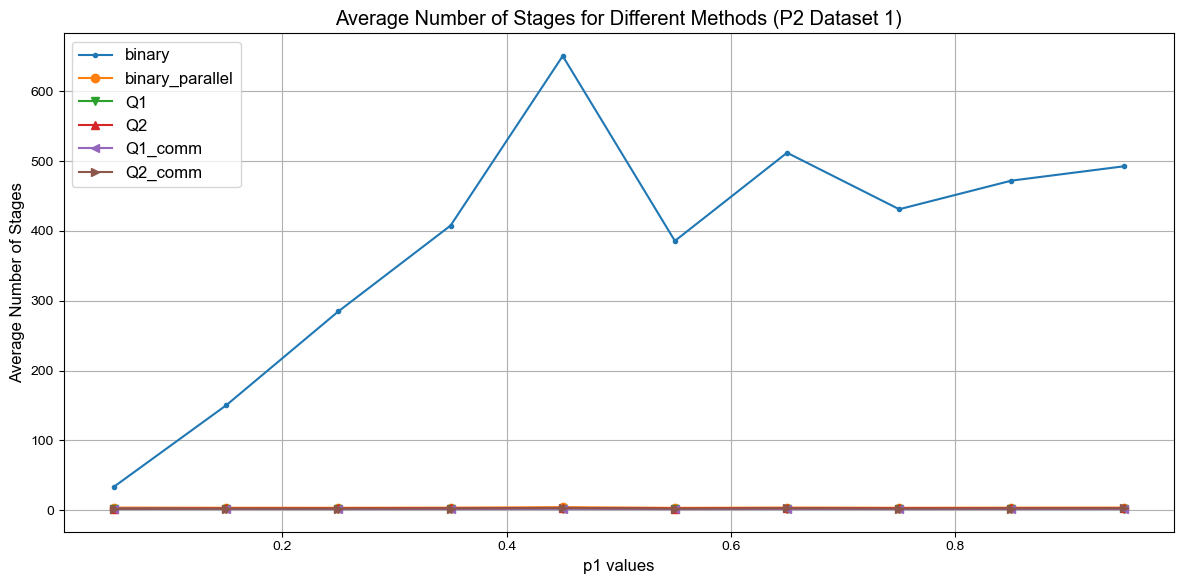

sbmN256_M64_SIM100_step2_q01_q10_p00.001_p10.05some_methodgraphs.pkl
Generating synthetic dataset!
Dataset done!
Data loaded!
Fraction of people infected: 0.0014453125
Fraction of families with at least one infected: 0.005
Average fraction of people infected in families: 0.0014453125
Average number of tests: {'binary': 4.27, 'binary_parallel': 7.1, 'Q1': 6.36, 'Q2': 6.45, 'Q1_comm': 65.28, 'Q2_comm': 65.28}
Average number of stages: {'binary': 4.27, 'binary_parallel': 4.24, 'Q1': 3.24, 'Q2': 3.16, 'Q1_comm': 1.32, 'Q2_comm': 1.32}
sbmN256_M64_SIM100_step2_q01_q10_p00.001_p10.15000000000000002some_methodgraphs.pkl
Generating synthetic dataset!
Dataset done!
Data loaded!
Fraction of people infected: 0.001953125
Fraction of families with at least one infected: 0.003125
Average fraction of people infected in families: 0.001953125
Average number of tests: {'binary': 5.29, 'binary_parallel': 8.42, 'Q1': 7.22, 'Q2': 7.18, 'Q1_comm': 64.8, 'Q2_comm': 64.8}
Average number of stages: {'binary': 

<Figure size 3600x1800 with 0 Axes>

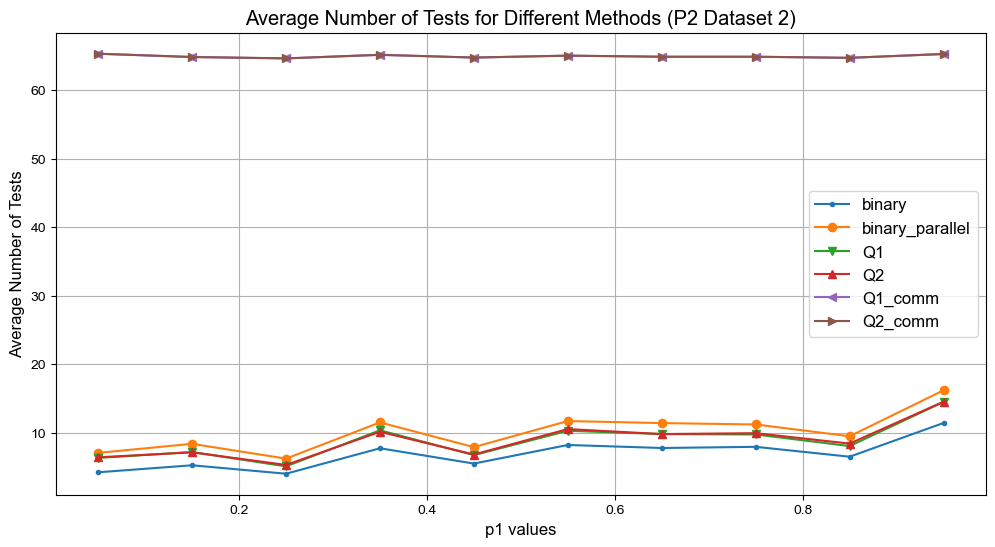

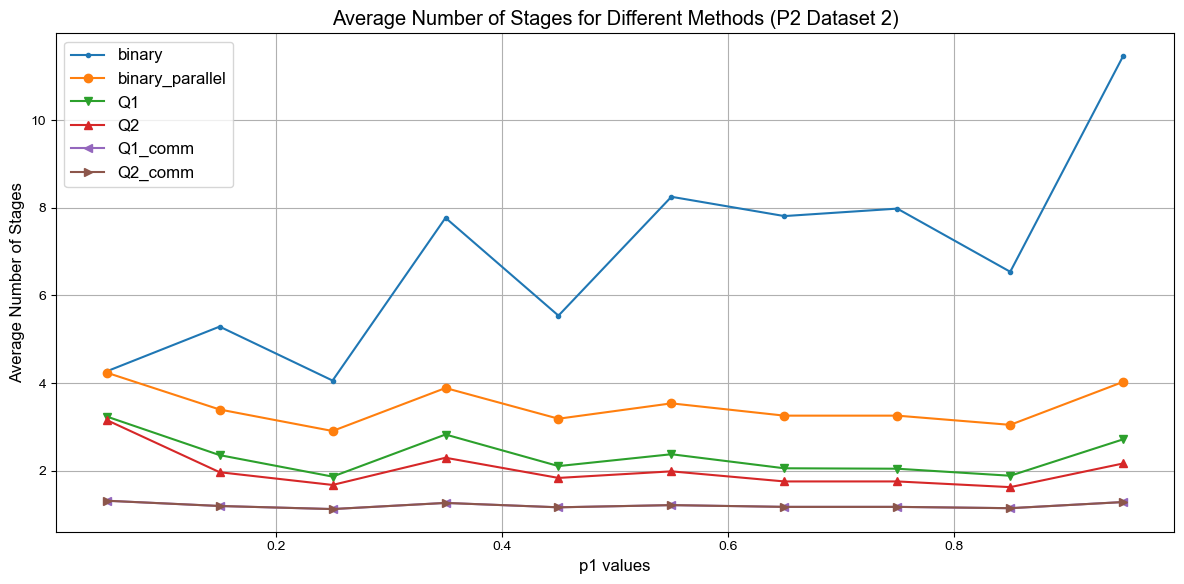

sbmN256_M64_SIM100_step2_q00.9_q10.1_p00.001_p10.05some_methodgraphs.pkl
Generating synthetic dataset!
Dataset done!
Data loaded!
Fraction of people infected: 0.01484375
Fraction of families with at least one infected: 0.26
Average fraction of people infected in families: 0.01484375
Average number of tests: {'binary': 31.72, 'binary_parallel': 33.16, 'Q1': 28.86, 'Q2': 28.42, 'Q1_comm': 7.56, 'Q2_comm': 7.74}
Average number of stages: {'binary': 31.72, 'binary_parallel': 3.82, 'Q1': 2.24, 'Q2': 2.3, 'Q1_comm': 2.31, 'Q2_comm': 2.07}
sbmN256_M64_SIM100_step2_q00.9_q10.1_p00.001_p10.15000000000000002some_methodgraphs.pkl
Generating synthetic dataset!
Dataset done!
Data loaded!
Fraction of people infected: 0.0826953125
Fraction of families with at least one infected: 0.27
Average fraction of people infected in families: 0.0826953125
Average number of tests: {'binary': 167.46, 'binary_parallel': 95.7, 'Q1': 86.93, 'Q2': 75.13, 'Q1_comm': 18.0, 'Q2_comm': 18.55}
Average number of stages: {'

<Figure size 3600x1800 with 0 Axes>

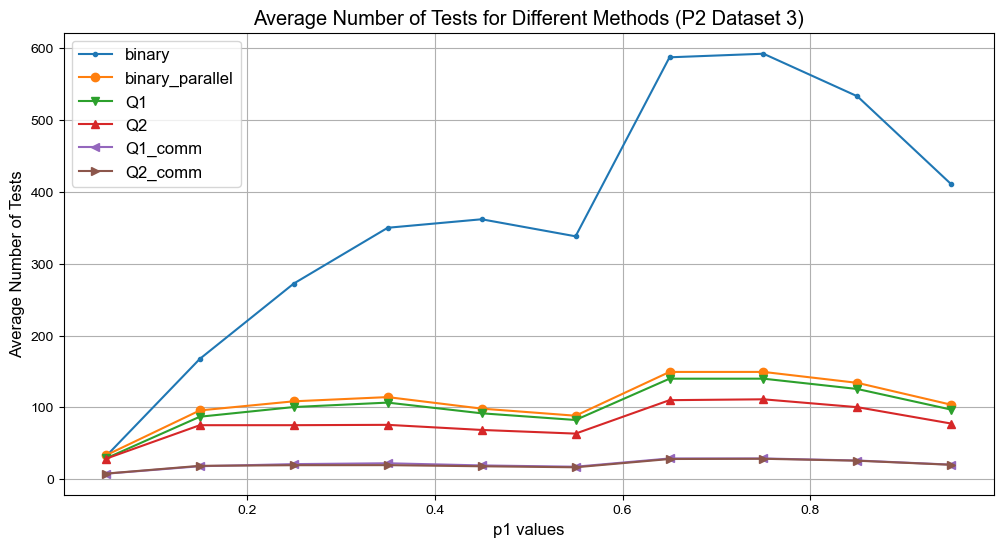

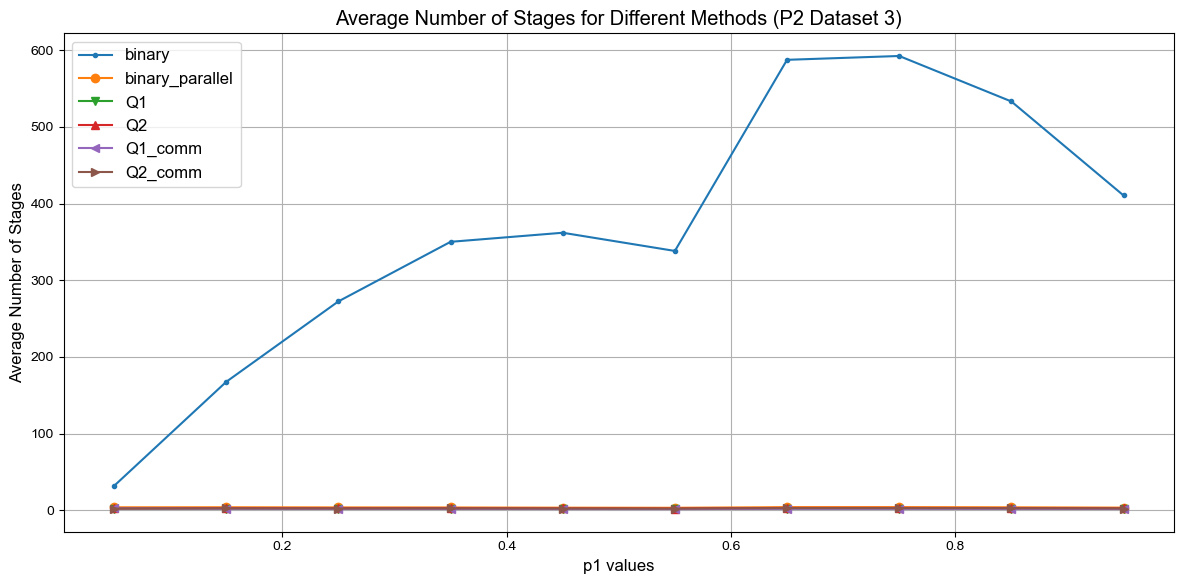

sbmN256_M64_SIM100_step2_q00.5_q10.2_p00.001_p10.05some_methodgraphs.pkl
Generating synthetic dataset!
Dataset done!
Data loaded!
Fraction of people infected: 0.0290625
Fraction of families with at least one infected: 0.22
Average fraction of people infected in families: 0.0290625
Average number of tests: {'binary': 59.55, 'binary_parallel': 48.54, 'Q1': 42.36, 'Q2': 41.57, 'Q1_comm': 10.58, 'Q2_comm': 10.97}
Average number of stages: {'binary': 59.55, 'binary_parallel': 3.54, 'Q1': 1.91, 'Q2': 2.35, 'Q1_comm': 1.99, 'Q2_comm': 2.0}
sbmN256_M64_SIM100_step2_q00.5_q10.2_p00.001_p10.15000000000000002some_methodgraphs.pkl
Generating synthetic dataset!
Dataset done!
Data loaded!
Fraction of people infected: 0.1566796875
Fraction of families with at least one infected: 0.25
Average fraction of people infected in families: 0.1566796875
Average number of tests: {'binary': 320.84, 'binary_parallel': 118.2, 'Q1': 109.95, 'Q2': 79.9, 'Q1_comm': 22.78, 'Q2_comm': 20.65}
Average number of stages: 

<Figure size 3600x1800 with 0 Axes>

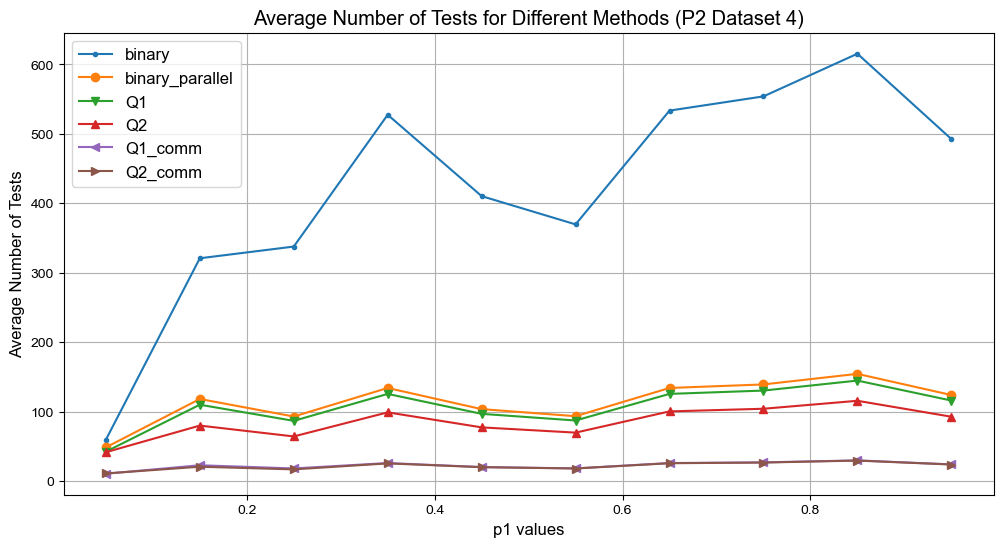

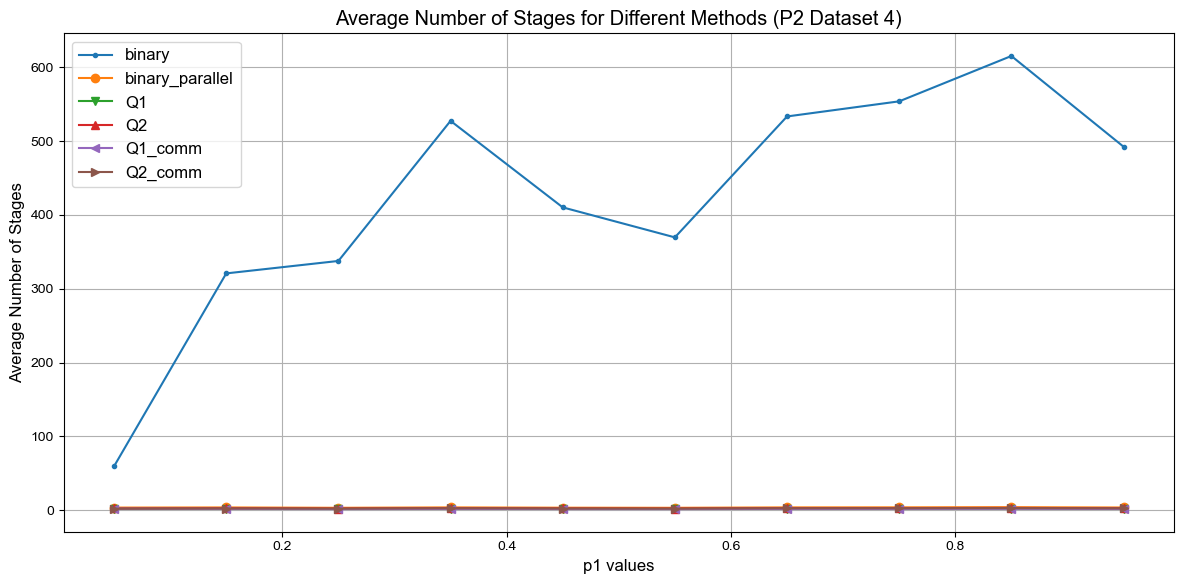

sbmN256_M128_SIM100_step2_q00.9_q10.1_p00.001_p10.05some_methodgraphs.pkl
Generating synthetic dataset!
Dataset done!
Data loaded!
Fraction of people infected: 0.0114453125
Fraction of families with at least one infected: 0.22
Average fraction of people infected in families: 0.0114453125
Average number of tests: {'binary': 24.31, 'binary_parallel': 26.4, 'Q1': 23.24, 'Q2': 22.68, 'Q1_comm': 6.67, 'Q2_comm': 6.42}
Average number of stages: {'binary': 24.31, 'binary_parallel': 3.54, 'Q1': 2.09, 'Q2': 2.05, 'Q1_comm': 2.15, 'Q2_comm': 2.0}
sbmN256_M128_SIM100_step2_q00.9_q10.1_p00.001_p10.15000000000000002some_methodgraphs.pkl
Generating synthetic dataset!
Dataset done!
Data loaded!
Fraction of people infected: 0.0560546875
Fraction of families with at least one infected: 0.23
Average fraction of people infected in families: 0.0560546875
Average number of tests: {'binary': 114.16, 'binary_parallel': 71.72, 'Q1': 64.25, 'Q2': 57.92, 'Q1_comm': 14.3, 'Q2_comm': 15.01}
Average number of stag

<Figure size 3600x1800 with 0 Axes>

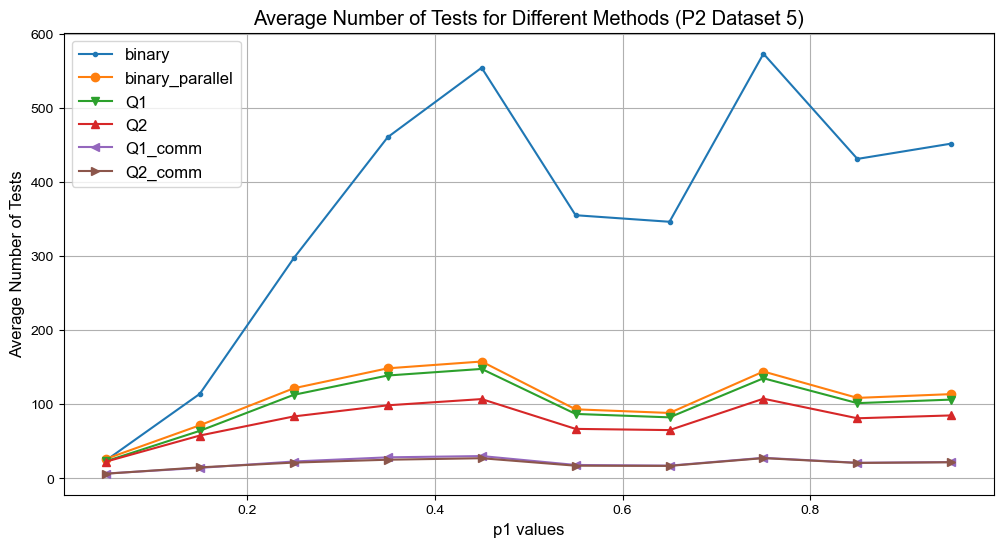

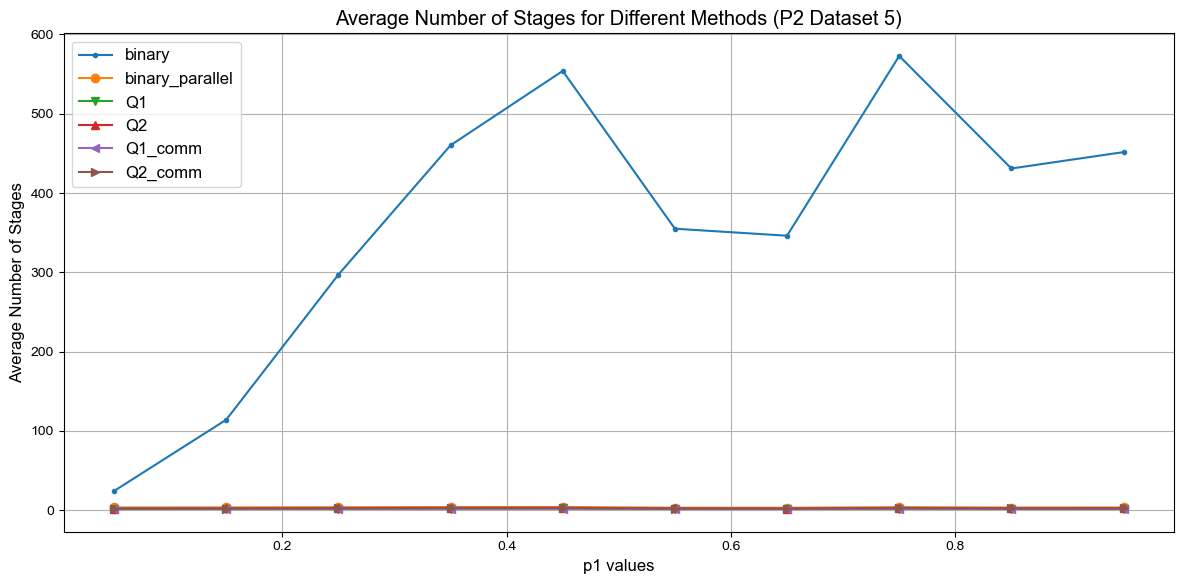

In [275]:
#TEST NUM 1
N = 256
M = 16
q0 = 0.9
q1 = 0.1
p0 = 0.001
p1_range = np.arange(0.05,1.05,0.1)
time_steps = 2
num_sims = 100
method = 'some_method'
dataset = 'sbm'

num_tests = []
num_stages = []
for p1 in p1_range:
    fraction_ppl, fraction_family, fraction_ppl_in_family, avg_num_tests, avg_num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, method, dataset)
    
    print(f'Fraction of people infected: {fraction_ppl}')
    print(f'Fraction of families with at least one infected: {fraction_family}')
    print(f'Average fraction of people infected in families: {fraction_ppl_in_family}')
    print('Average number of tests:', avg_num_tests)
    print('Average number of stages:', avg_num_stages)
    
    num_tests.append(avg_num_tests)
    num_stages.append(avg_num_stages)

def plot_iter_results(num_tests, num_stages):
    
    methods = ['binary', 'binary_parallel', 'Q1', 'Q2', 'Q1_comm', 'Q2_comm']
    markers = ['.', 'o', 'v', '^', '<', '>']
    
    plt.figure(figsize=(12, 6), dpi=300)
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'sans-serif',
        'font.sans-serif': 'Arial',
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })

    # Plot average number of tests for each method
    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods):
        avg_tests = [test[method] for test in num_tests]
        plt.plot(p1_range, avg_tests, label=method, marker=markers[i])
    plt.xlabel('p1 values')
    plt.ylabel('Average Number of Tests')
    plt.title('Average Number of Tests for Different Methods (P2 Dataset 1)')
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods):
        avg_stages = [stage[method] for stage in num_stages]
        plt.plot(p1_range, avg_stages, label=method, marker=markers[i])
    plt.xlabel('p1 values')
    plt.ylabel('Average Number of Stages')
    plt.title('Average Number of Stages for Different Methods (P2 Dataset 1)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_iter_results(num_tests, num_stages)

#TEST NUM 2
N = 256
M = 64
q0 = 1
q1 = 0
p0 = 0.001
p1_range = np.arange(0.05,1.05,0.1)
time_steps = 2
num_sims = 100
method = 'some_method'
dataset = 'sbm'

num_tests = []
num_stages = []
for p1 in p1_range:
    fraction_ppl, fraction_family, fraction_ppl_in_family, avg_num_tests, avg_num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, method, dataset)
    
    print(f'Fraction of people infected: {fraction_ppl}')
    print(f'Fraction of families with at least one infected: {fraction_family}')
    print(f'Average fraction of people infected in families: {fraction_ppl_in_family}')
    print('Average number of tests:', avg_num_tests)
    print('Average number of stages:', avg_num_stages)
    
    num_tests.append(avg_num_tests)
    num_stages.append(avg_num_stages)

def plot_iter_results(num_tests, num_stages):
    
    methods = ['binary', 'binary_parallel', 'Q1', 'Q2', 'Q1_comm', 'Q2_comm']
    markers = ['.', 'o', 'v', '^', '<', '>']
    
    plt.figure(figsize=(12, 6), dpi=300)
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'sans-serif',
        'font.sans-serif': 'Arial',
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })

    # Plot average number of tests for each method
    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods):
        avg_tests = [test[method] for test in num_tests]
        plt.plot(p1_range, avg_tests, label=method, marker=markers[i])
    plt.xlabel('p1 values')
    plt.ylabel('Average Number of Tests')
    plt.title('Average Number of Tests for Different Methods (P2 Dataset 2)')
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods):
        avg_stages = [stage[method] for stage in num_stages]
        plt.plot(p1_range, avg_stages, label=method, marker=markers[i])
    plt.xlabel('p1 values')
    plt.ylabel('Average Number of Stages')
    plt.title('Average Number of Stages for Different Methods (P2 Dataset 2)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_iter_results(num_tests, num_stages)


#TEST NUM 3
N = 256
M = 64
q0 = 0.9
q1 = 0.1
p0 = 0.001
p1_range = np.arange(0.05,1.05,0.1)
time_steps = 2
num_sims = 100
method = 'some_method'
dataset = 'sbm'

num_tests = []
num_stages = []
for p1 in p1_range:
    fraction_ppl, fraction_family, fraction_ppl_in_family, avg_num_tests, avg_num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, method, dataset)
    
    print(f'Fraction of people infected: {fraction_ppl}')
    print(f'Fraction of families with at least one infected: {fraction_family}')
    print(f'Average fraction of people infected in families: {fraction_ppl_in_family}')
    print('Average number of tests:', avg_num_tests)
    print('Average number of stages:', avg_num_stages)
    
    num_tests.append(avg_num_tests)
    num_stages.append(avg_num_stages)

def plot_iter_results(num_tests, num_stages):
    
    methods = ['binary', 'binary_parallel', 'Q1', 'Q2', 'Q1_comm', 'Q2_comm']
    markers = ['.', 'o', 'v', '^', '<', '>']
    
    plt.figure(figsize=(12, 6), dpi=300)
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'sans-serif',
        'font.sans-serif': 'Arial',
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })

    # Plot average number of tests for each method
    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods):
        avg_tests = [test[method] for test in num_tests]
        plt.plot(p1_range, avg_tests, label=method, marker=markers[i])
    plt.xlabel('p1 values')
    plt.ylabel('Average Number of Tests')
    plt.title('Average Number of Tests for Different Methods (P2 Dataset 3)')
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods):
        avg_stages = [stage[method] for stage in num_stages]
        plt.plot(p1_range, avg_stages, label=method, marker=markers[i])
    plt.xlabel('p1 values')
    plt.ylabel('Average Number of Stages')
    plt.title('Average Number of Stages for Different Methods (P2 Dataset 3)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_iter_results(num_tests, num_stages)

#TEST NUM 4
N = 256
M = 64
q0 = 0.5
q1 = 0.2
p0 = 0.001
p1_range = np.arange(0.05,1.05,0.1)
time_steps = 2
num_sims = 100
method = 'some_method'
dataset = 'sbm'

num_tests = []
num_stages = []
for p1 in p1_range:
    fraction_ppl, fraction_family, fraction_ppl_in_family, avg_num_tests, avg_num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, method, dataset)
    
    print(f'Fraction of people infected: {fraction_ppl}')
    print(f'Fraction of families with at least one infected: {fraction_family}')
    print(f'Average fraction of people infected in families: {fraction_ppl_in_family}')
    print('Average number of tests:', avg_num_tests)
    print('Average number of stages:', avg_num_stages)
    
    num_tests.append(avg_num_tests)
    num_stages.append(avg_num_stages)

def plot_iter_results(num_tests, num_stages):
    
    methods = ['binary', 'binary_parallel', 'Q1', 'Q2', 'Q1_comm', 'Q2_comm']
    markers = ['.', 'o', 'v', '^', '<', '>']
    
    plt.figure(figsize=(12, 6), dpi=300)
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'sans-serif',
        'font.sans-serif': 'Arial',
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })

    # Plot average number of tests for each method
    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods):
        avg_tests = [test[method] for test in num_tests]
        plt.plot(p1_range, avg_tests, label=method, marker=markers[i])
    plt.xlabel('p1 values')
    plt.ylabel('Average Number of Tests')
    plt.title('Average Number of Tests for Different Methods (P2 Dataset 4)')
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods):
        avg_stages = [stage[method] for stage in num_stages]
        plt.plot(p1_range, avg_stages, label=method, marker=markers[i])
    plt.xlabel('p1 values')
    plt.ylabel('Average Number of Stages')
    plt.title('Average Number of Stages for Different Methods (P2 Dataset 4)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_iter_results(num_tests, num_stages)

#TEST NUM 5
N = 256
M = 128
q0 = 0.9
q1 = 0.1
p0 = 0.001
p1_range = np.arange(0.05,1.05,0.1)
time_steps = 2
num_sims = 100
method = 'some_method'
dataset = 'sbm'

num_tests = []
num_stages = []
for p1 in p1_range:
    fraction_ppl, fraction_family, fraction_ppl_in_family, avg_num_tests, avg_num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, method, dataset)
    
    print(f'Fraction of people infected: {fraction_ppl}')
    print(f'Fraction of families with at least one infected: {fraction_family}')
    print(f'Average fraction of people infected in families: {fraction_ppl_in_family}')
    print('Average number of tests:', avg_num_tests)
    print('Average number of stages:', avg_num_stages)
    
    num_tests.append(avg_num_tests)
    num_stages.append(avg_num_stages)

def plot_iter_results(num_tests, num_stages):
    
    methods = ['binary', 'binary_parallel', 'Q1', 'Q2', 'Q1_comm', 'Q2_comm']
    markers = ['.', 'o', 'v', '^', '<', '>']
    
    plt.figure(figsize=(12, 6), dpi=300)
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'sans-serif',
        'font.sans-serif': 'Arial',
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })

    # Plot average number of tests for each method
    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods):
        avg_tests = [test[method] for test in num_tests]
        plt.plot(p1_range, avg_tests, label=method, marker=markers[i])
    plt.xlabel('p1 values')
    plt.ylabel('Average Number of Tests')
    plt.title('Average Number of Tests for Different Methods (P2 Dataset 5)')
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods):
        avg_stages = [stage[method] for stage in num_stages]
        plt.plot(p1_range, avg_stages, label=method, marker=markers[i])
    plt.xlabel('p1 values')
    plt.ylabel('Average Number of Stages')
    plt.title('Average Number of Stages for Different Methods (P2 Dataset 5)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_iter_results(num_tests, num_stages)

iidN256_M256_SIM100_step0_q00_q10_p00.01_p10some_methodgraphs.pkl
Generating synthetic dataset!
Dataset done!
Data loaded!
Fraction of people infected: 0.0108984375
Fraction of families with at least one infected: 0.91
Average fraction of people infected in families: 0.0108984375
Average number of tests: {'binary': 24.49, 'binary_parallel': 35.3, 'Q1': 33.37, 'Q2': 33.08, 'Q1_comm': 10.03, 'Q2_comm': 10.2}
Average number of stages: {'binary': 24.49, 'binary_parallel': 8.37, 'Q1': 7.04, 'Q2': 5.5, 'Q1_comm': 4.69, 'Q2_comm': 4.32}
iidN256_M256_SIM100_step0_q00_q10_p00.02_p10some_methodgraphs.pkl
Generating synthetic dataset!
Dataset done!
Data loaded!
Fraction of people infected: 0.019375
Fraction of families with at least one infected: 1.0
Average fraction of people infected in families: 0.019375
Average number of tests: {'binary': 41.79, 'binary_parallel': 56.56, 'Q1': 52.66, 'Q2': 51.64, 'Q1_comm': 13.88, 'Q2_comm': 13.75}
Average number of stages: {'binary': 41.79, 'binary_parallel'

<Figure size 3600x1800 with 0 Axes>

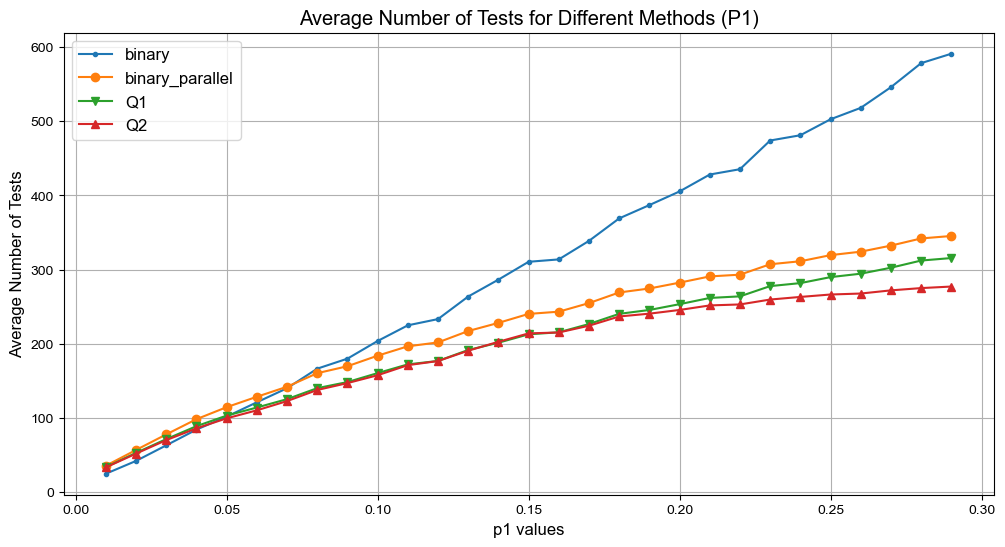

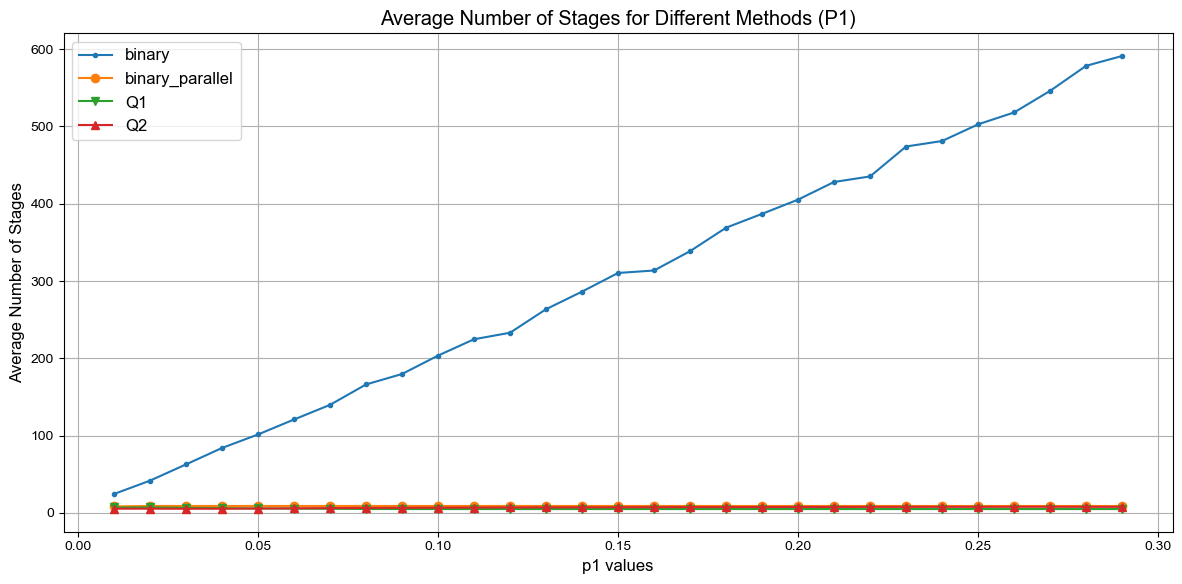

In [280]:
# IID Test
N = 256
M = 256
q0 = 0
q1 = 0
p0_range = np.arange(0.01, 0.3, 0.01)
p1 = 0
time_steps = 0
num_sims = 100
method = 'some_method'
dataset = 'iid'

num_tests = []
num_stages = []
for p0 in p0_range:
    fraction_ppl, fraction_family, fraction_ppl_in_family, avg_num_tests, avg_num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, method, dataset)
    
    print(f'Fraction of people infected: {fraction_ppl}')
    print(f'Fraction of families with at least one infected: {fraction_family}')
    print(f'Average fraction of people infected in families: {fraction_ppl_in_family}')
    print('Average number of tests:', avg_num_tests)
    print('Average number of stages:', avg_num_stages)
    
    num_tests.append(avg_num_tests)
    num_stages.append(avg_num_stages)

def plot_iter_results(num_tests, num_stages):
    
    methods = ['binary', 'binary_parallel', 'Q1', 'Q2']
    markers = ['.', 'o', 'v', '^', '<', '>']
    
    plt.figure(figsize=(12, 6), dpi=300)
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'sans-serif',
        'font.sans-serif': 'Arial',
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })

    # Plot average number of tests for each method
    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods):
        avg_tests = [test[method] for test in num_tests]
        plt.plot(p0_range, avg_tests, label=method, marker=markers[i])
    plt.xlabel('p1 values')
    plt.ylabel('Average Number of Tests')
    plt.title('Average Number of Tests for Different Methods (P1)')
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods):
        avg_stages = [stage[method] for stage in num_stages]
        plt.plot(p0_range, avg_stages, label=method, marker=markers[i])
    plt.xlabel('p1 values')
    plt.ylabel('Average Number of Stages')
    plt.title('Average Number of Stages for Different Methods (P1)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_iter_results(num_tests, num_stages)   

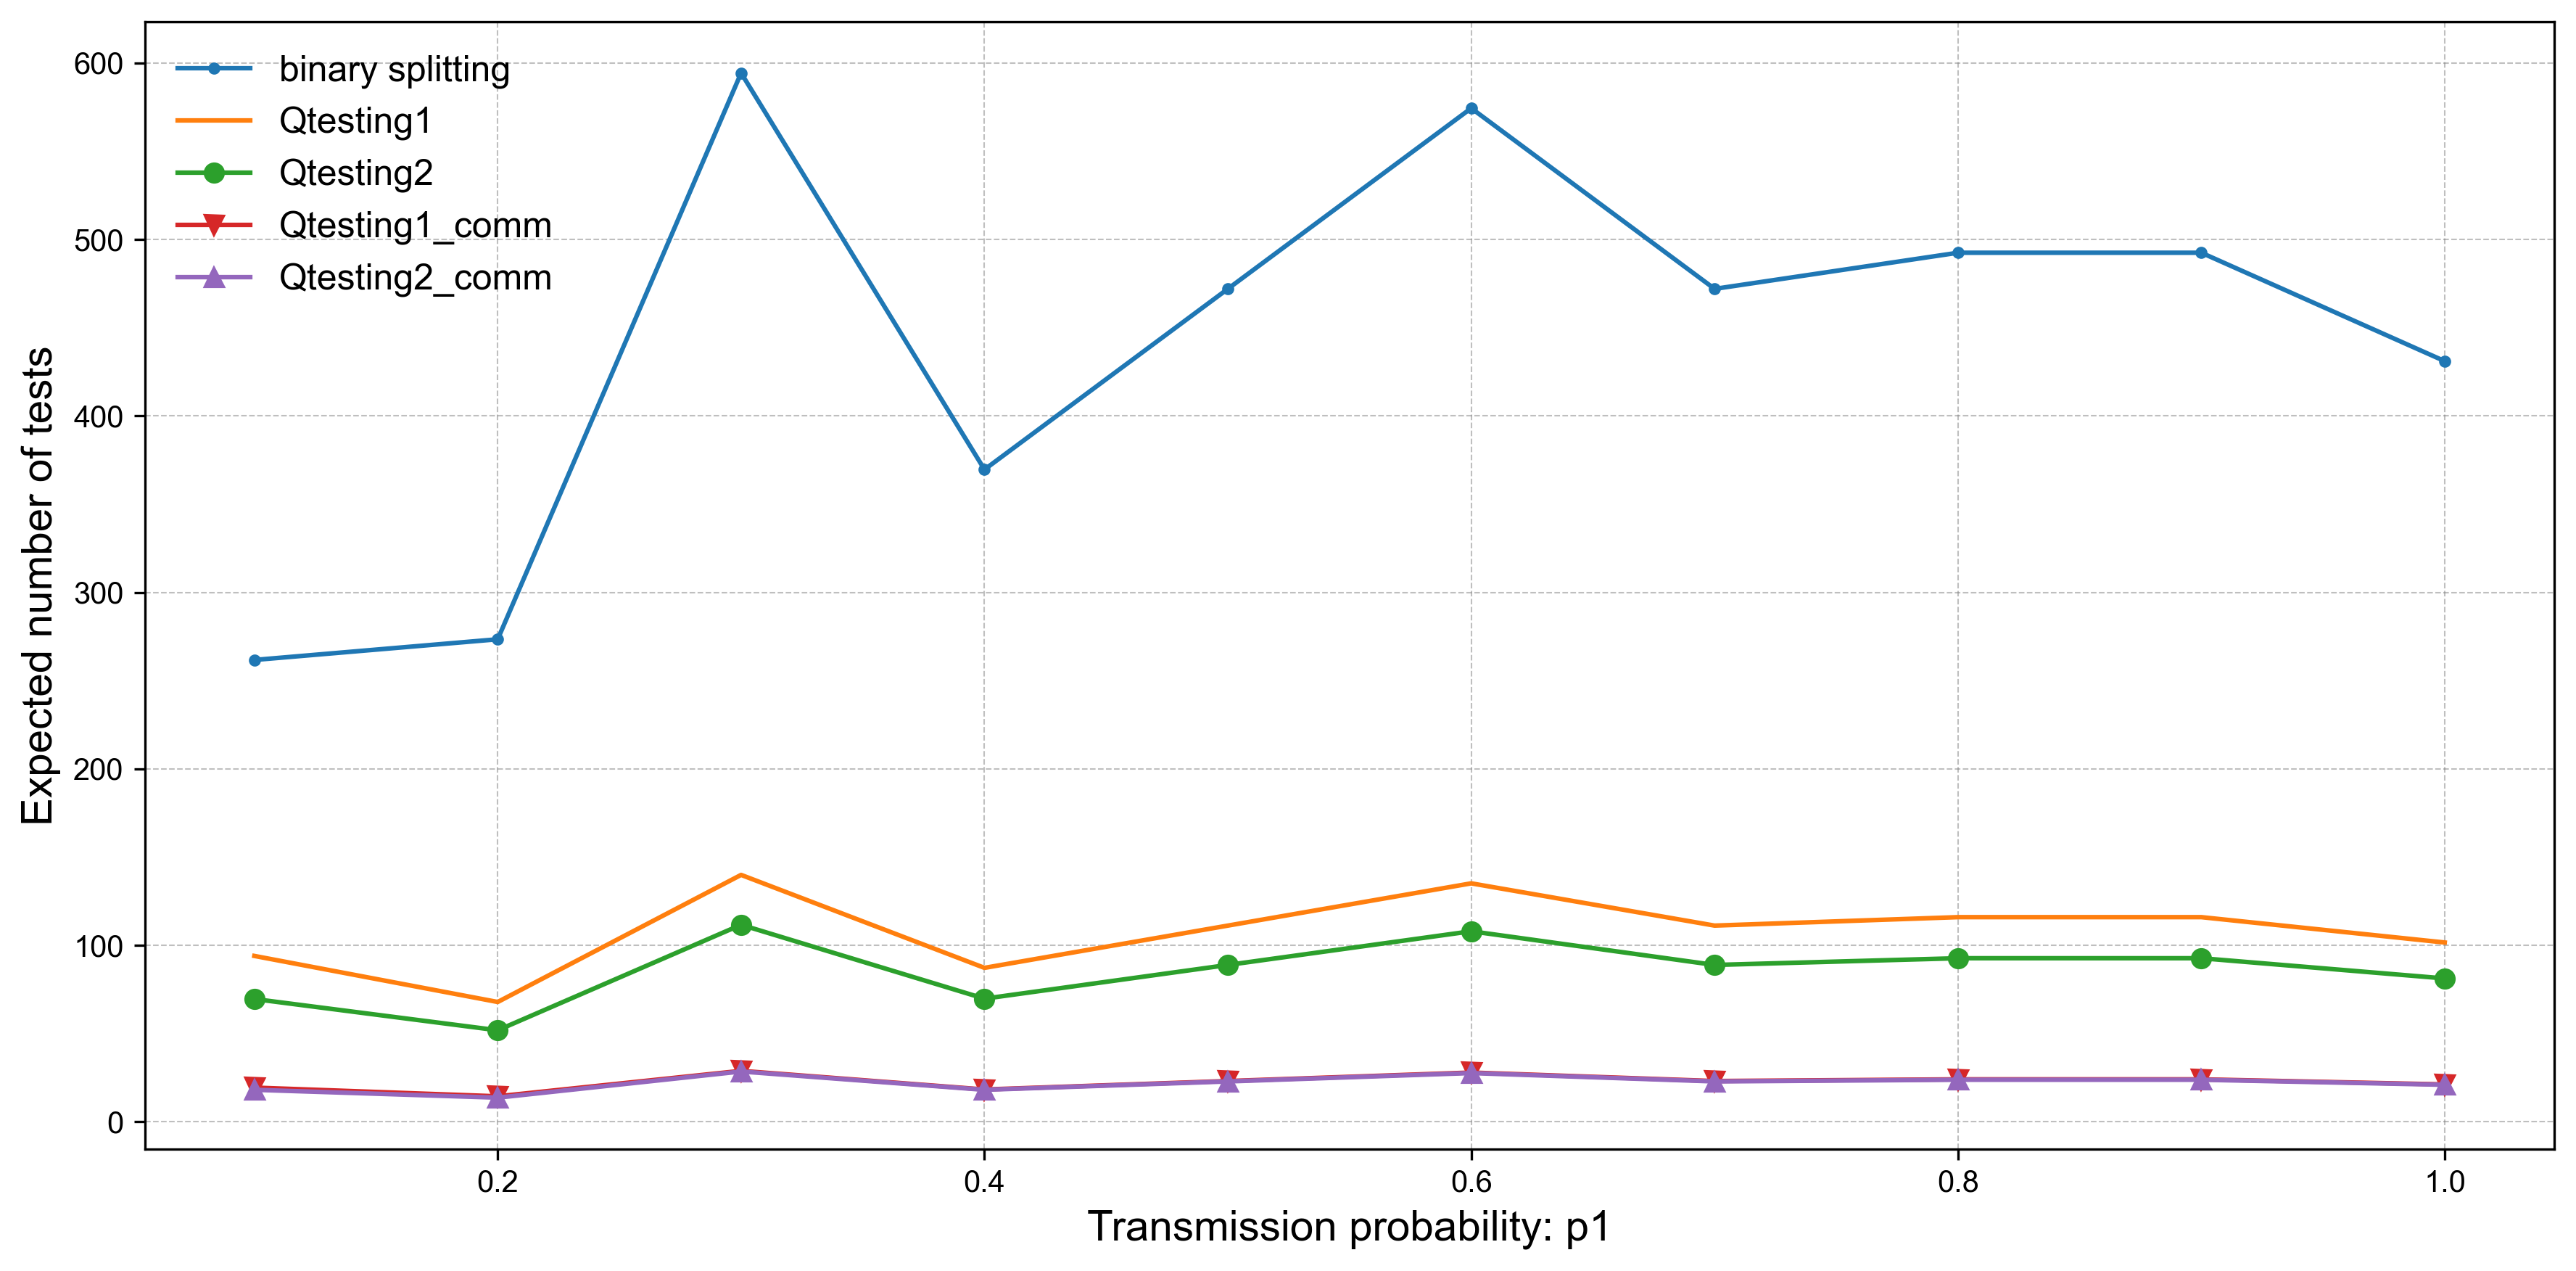

In [195]:
plt.figure(figsize=(12, 6), dpi=300)
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})
markers = ['.', ',', 'o', 'v', '^', '<', '>']
   

#########your code here###########
for i in range(5):
    plt.plot(p1s, num_tests[:, i], label=['binary splitting', 'Qtesting1', 'Qtesting2', 'Qtesting1_comm', 'Qtesting2_comm'][i], marker=markers[i])
    
plt.xlabel('Transmission probability: p1', fontsize=14)
plt.ylabel('Expected number of tests', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(frameon=False, loc='best')
plt.tight_layout()
fig_name = f'RES_N{N}_M{M}_SIM{num_sims}_step{time_steps}_q0{q0}_q1{q1}_p0{p0}_{method}_GT.pdf'
plt.savefig(fig_name, format='pdf', bbox_inches='tight')
plt.show()

sbmN256_M16_SIM100_step2_q01_q10_p00.001_p10.05some_methodgraphs.pkl
Data loaded!
Fraction of people infected: 0.0025
Fraction of families with at least one infected: 0.014375
Average fraction of people infected in families: 0.0025
Average number of tests: {'binary': 6.35, 'binary_parallel': 9.46, 'Q1': 8.19, 'Q2': 8.03, 'Q1_comm': 16.62, 'Q2_comm': 16.71}
Average number of stages: {'binary': 6.35, 'binary_parallel': 3.47, 'Q1': 2.38, 'Q2': 2.11, 'Q1_comm': 1.34, 'Q2_comm': 1.41}
sbmN256_M16_SIM100_step2_q01_q10_p00.001_p10.15000000000000002some_methodgraphs.pkl
Data loaded!
Fraction of people infected: 0.0084765625
Fraction of families with at least one infected: 0.015625
Average fraction of people infected in families: 0.0084765625
Average number of tests: {'binary': 18.5, 'binary_parallel': 22.66, 'Q1': 19.85, 'Q2': 19.41, 'Q1_comm': 16.97, 'Q2_comm': 17.19}
Average number of stages: {'binary': 18.5, 'binary_parallel': 3.61, 'Q1': 2.2, 'Q2': 2.04, 'Q1_comm': 1.45, 'Q2_comm': 1.5}
sb

<Figure size 3600x1800 with 0 Axes>

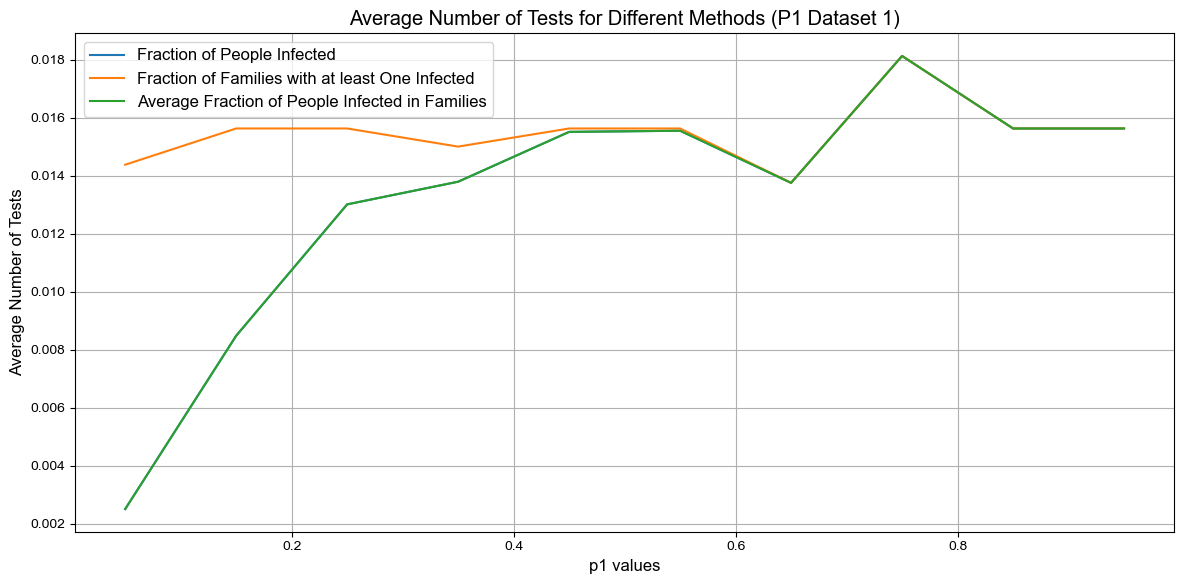

sbmN256_M16_SIM100_step2_q00.9_q10.1_p00.001_p10.05some_methodgraphs.pkl
Data loaded!
Fraction of people infected: 0.0159765625
Fraction of families with at least one infected: 0.24
Average fraction of people infected in families: 0.0159765625
Average number of tests: {'binary': 33.46, 'binary_parallel': 34.08, 'Q1': 29.58, 'Q2': 29.01, 'Q1_comm': 7.87, 'Q2_comm': 7.76}
Average number of stages: {'binary': 33.46, 'binary_parallel': 3.68, 'Q1': 2.09, 'Q2': 2.23, 'Q1_comm': 2.24, 'Q2_comm': 2.0}
sbmN256_M16_SIM100_step2_q00.9_q10.1_p00.001_p10.15000000000000002some_methodgraphs.pkl
Data loaded!
Fraction of people infected: 0.07359375
Fraction of families with at least one infected: 0.21
Average fraction of people infected in families: 0.07359375
Average number of tests: {'binary': 149.91, 'binary_parallel': 79.24, 'Q1': 72.17, 'Q2': 60.5, 'Q1_comm': 15.36, 'Q2_comm': 15.63}
Average number of stages: {'binary': 149.91, 'binary_parallel': 3.47, 'Q1': 1.84, 'Q2': 2.38, 'Q1_comm': 1.69, 'Q2_

<Figure size 3600x1800 with 0 Axes>

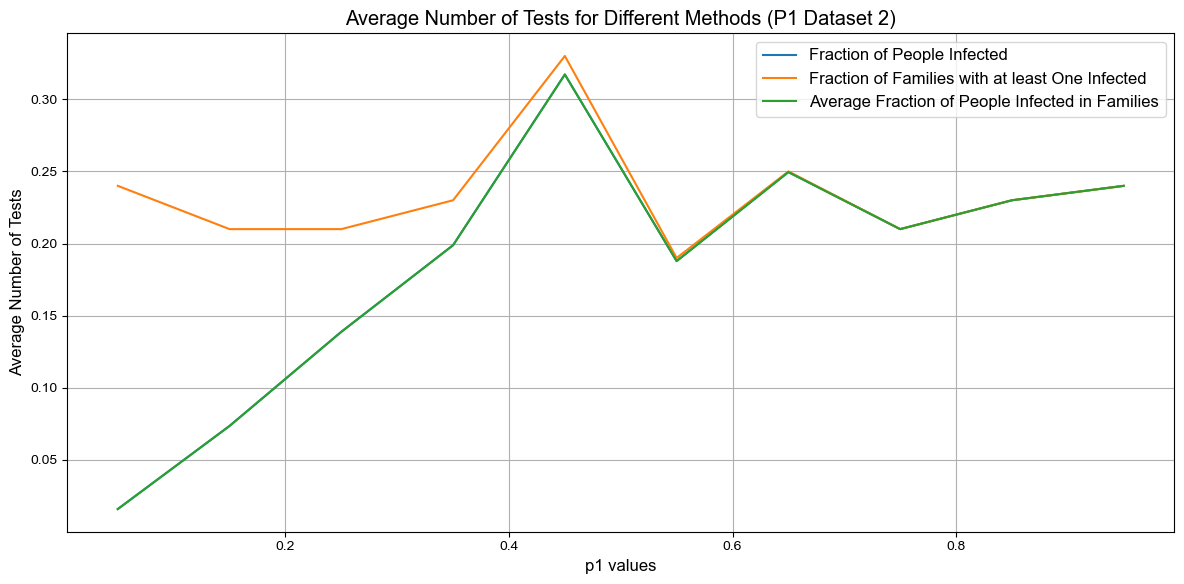

sbmN256_M16_SIM100_step2_q00.5_q10.3_p00.001_p10.05some_methodgraphs.pkl
Data loaded!
Fraction of people infected: 0.0459375
Fraction of families with at least one infected: 0.22
Average fraction of people infected in families: 0.0459375
Average number of tests: {'binary': 94.15, 'binary_parallel': 63.74, 'Q1': 56.7, 'Q2': 53.13, 'Q1_comm': 13.2, 'Q2_comm': 13.88}
Average number of stages: {'binary': 94.15, 'binary_parallel': 3.54, 'Q1': 1.88, 'Q2': 2.44, 'Q1_comm': 1.88, 'Q2_comm': 2.11}
sbmN256_M16_SIM100_step2_q00.5_q10.3_p00.001_p10.15000000000000002some_methodgraphs.pkl
Data loaded!
Fraction of people infected: 0.1562109375
Fraction of families with at least one infected: 0.18
Average fraction of people infected in families: 0.1562109375
Average number of tests: {'binary': 320.66, 'binary_parallel': 92.38, 'Q1': 86.16, 'Q2': 62.46, 'Q1_comm': 17.98, 'Q2_comm': 16.24}
Average number of stages: {'binary': 320.66, 'binary_parallel': 3.26, 'Q1': 1.72, 'Q2': 2.26, 'Q1_comm': 1.54, 'Q2_

<Figure size 3600x1800 with 0 Axes>

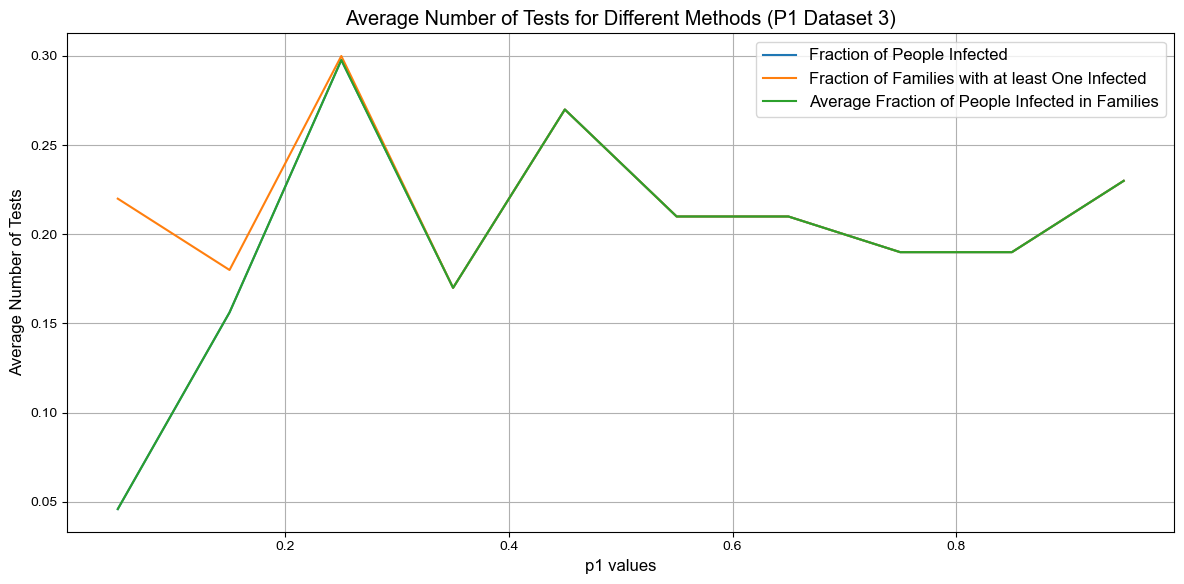

In [286]:
#SYNTHETIC TEST 1
N = 256
M = 16
q0 = 1
q1 = 0
p0 = 0.001
p1_range = np.arange(0.05,1.05,0.1)
time_steps = 2
num_sims = 100
method = 'some_method'
dataset = 'sbm'

frac_ppl = []
frac_fam = []
frac_ppl_in_fam = []
for p1 in p1_range:
    fraction_ppl, fraction_family, fraction_ppl_in_family, avg_num_tests, avg_num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, method, dataset)
    
    print(f'Fraction of people infected: {fraction_ppl}')
    print(f'Fraction of families with at least one infected: {fraction_family}')
    print(f'Average fraction of people infected in families: {fraction_ppl_in_family}')
    print('Average number of tests:', avg_num_tests)
    print('Average number of stages:', avg_num_stages)
    
    frac_ppl.append(fraction_ppl)
    frac_fam.append(fraction_family)
    frac_ppl_in_fam.append(fraction_ppl_in_family)

def plot_iter_results(frac_ppl, frac_fam, frac_ppl_in_fam):
    
    plt.figure(figsize=(12, 6), dpi=300)
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'sans-serif',
        'font.sans-serif': 'Arial',
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })

    # Plot average number of tests for each method
    plt.figure(figsize=(12, 6))
    
    infected_ppl = [test for test in frac_ppl]
    plt.plot(p1_range, infected_ppl, label='Fraction of People Infected')

    infected_fam = [test for test in frac_fam]
    plt.plot(p1_range, infected_fam, label='Fraction of Families with at least One Infected')

    infected_fam_portion = [test for test in frac_ppl_in_fam]
    plt.plot(p1_range, infected_fam_portion, label='Average Fraction of People Infected in Families')
        
    plt.xlabel('p1 values')
    plt.ylabel('Average Number of Tests')
    plt.title('Average Number of Tests for Different Methods (P1 Dataset 1)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_iter_results(frac_ppl, frac_fam, frac_ppl_in_fam)

#SYNTHETIC TEST 2
N = 256
M = 16
q0 = 0.9
q1 = 0.1
p0 = 0.001
p1_range = np.arange(0.05,1.05,0.1)
time_steps = 2
num_sims = 100
method = 'some_method'
dataset = 'sbm'

frac_ppl = []
frac_fam = []
frac_ppl_in_fam = []
for p1 in p1_range:
    fraction_ppl, fraction_family, fraction_ppl_in_family, avg_num_tests, avg_num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, method, dataset)
    
    print(f'Fraction of people infected: {fraction_ppl}')
    print(f'Fraction of families with at least one infected: {fraction_family}')
    print(f'Average fraction of people infected in families: {fraction_ppl_in_family}')
    print('Average number of tests:', avg_num_tests)
    print('Average number of stages:', avg_num_stages)
    
    frac_ppl.append(fraction_ppl)
    frac_fam.append(fraction_family)
    frac_ppl_in_fam.append(fraction_ppl_in_family)

def plot_iter_results(frac_ppl, frac_fam, frac_ppl_in_fam):

    markers = ['.', 'o', 'v', '^', '<', '>']
    
    plt.figure(figsize=(12, 6), dpi=300)
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'sans-serif',
        'font.sans-serif': 'Arial',
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })

    # Plot average number of tests for each method
    plt.figure(figsize=(12, 6))

    infected_ppl = [test for test in frac_ppl]
    plt.plot(p1_range, infected_ppl, label='Fraction of People Infected')

    infected_fam = [test for test in frac_fam]
    plt.plot(p1_range, infected_fam, label='Fraction of Families with at least One Infected')

    infected_fam_portion = [test for test in frac_ppl_in_fam]
    plt.plot(p1_range, infected_fam_portion, label='Average Fraction of People Infected in Families')
        
    plt.xlabel('p1 values')
    plt.ylabel('Average Number of Tests')
    plt.title('Average Number of Tests for Different Methods (P1 Dataset 2)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_iter_results(frac_ppl, frac_fam, frac_ppl_in_fam)

#SYNTHETIC TEST 3
N = 256
M = 16
q0 = 0.5
q1 = 0.3
p0 = 0.001
p1_range = np.arange(0.05,1.05,0.1)
time_steps = 2
num_sims = 100
method = 'some_method'
dataset = 'sbm'

frac_ppl = []
frac_fam = []
frac_ppl_in_fam = []
for p1 in p1_range:
    fraction_ppl, fraction_family, fraction_ppl_in_family, avg_num_tests, avg_num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, method, dataset)
    
    print(f'Fraction of people infected: {fraction_ppl}')
    print(f'Fraction of families with at least one infected: {fraction_family}')
    print(f'Average fraction of people infected in families: {fraction_ppl_in_family}')
    print('Average number of tests:', avg_num_tests)
    print('Average number of stages:', avg_num_stages)
    
    frac_ppl.append(fraction_ppl)
    frac_fam.append(fraction_family)
    frac_ppl_in_fam.append(fraction_ppl_in_family)

def plot_iter_results(frac_ppl, frac_fam, frac_ppl_in_fam):

    #markers = ['.', 'o', 'v', '^', '<', '>']
    
    plt.figure(figsize=(12, 6), dpi=300)
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'sans-serif',
        'font.sans-serif': 'Arial',
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })

    # Plot average number of tests for each method
    plt.figure(figsize=(12, 6))

    infected_ppl = [test for test in frac_ppl]
    plt.plot(p1_range, infected_ppl, label='Fraction of People Infected')

    infected_fam = [test for test in frac_fam]
    plt.plot(p1_range, infected_fam, label='Fraction of Families with at least One Infected')

    infected_fam_portion = [test for test in frac_ppl_in_fam]
    plt.plot(p1_range, infected_fam_portion, label='Average Fraction of People Infected in Families')
        
    plt.xlabel('p1 values')
    plt.ylabel('Average Number of Tests')
    plt.title('Average Number of Tests for Different Methods (P1 Dataset 3)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_iter_results(frac_ppl, frac_fam, frac_ppl_in_fam)

In [287]:
# Unit tests for sbm.py, infect.py, and algos.py
def test_SBM():
    N = 100
    M = 5
    q0 = 0.8
    q1 = 0.2
    G = SBM(N, M, q0, q1)
    assert G.shape == (N, N), "SBM output has incorrect shape"
    assert np.all((G == 0) | (G == 1)), "SBM output is not a binary matrix"
    print("SBM test passed!")

def test_infect():
    N = 100
    G = np.ones((N, N))
    p0 = 0.1
    p1 = 0.05
    time_steps = 2
    individuals = infect(G, p0, p1, time_steps)
    assert len(individuals) == N, "Infect output has incorrect length"
    assert np.all((individuals == 0) | (individuals == 1)), "Infect output is not binary"
    print("Infect test passed!")

def test_algos():
    N = 100
    infected_individuals = np.zeros(N)
    infected_individuals[:10] = 1
    np.random.shuffle(infected_individuals)
    
    num_tests_bin, num_stages_bin, _ = binary_splitting(infected_individuals)
    assert isinstance(num_tests_bin, int) and num_tests_bin > 0, "Binary splitting test count is invalid"
    assert isinstance(num_stages_bin, int) and num_stages_bin > 0, "Binary splitting stage count is invalid"
    
    num_tests_diag, num_stages_diag = diag_splitting(infected_individuals)
    assert isinstance(num_tests_diag, int) and num_tests_diag > 0, "Diagonal splitting test count is invalid"
    assert isinstance(num_stages_diag, int) and num_stages_diag > 0, "Diagonal splitting stage count is invalid"
    
    num_tests_q1, num_stages_q1, _ = Qtesting1(infected_individuals)
    assert isinstance(num_tests_q1, int) and num_tests_q1 > 0, "Qtesting1 test count is invalid"
    assert isinstance(num_stages_q1, int) and num_stages_q1 > 0, "Qtesting1 stage count is invalid"
    
    num_tests_q2, num_stages_q2, _ = Qtesting2(infected_individuals)
    assert isinstance(num_tests_q2, int) and num_tests_q2 > 0, "Qtesting2 test count is invalid"
    assert isinstance(num_stages_q2, int) and num_stages_q2 > 0, "Qtesting2 stage count is invalid"
    
    communities = [list(range(20)), list(range(20, 40)), list(range(40, 60)), list(range(60, 80)), list(range(80, 100))]
    
    num_tests_q1_c, num_stages_q1_c, _ = Qtesting1_comm_aware(infected_individuals, communities)
    assert isinstance(num_tests_q1_c, int) and num_tests_q1_c > 0, "Qtesting1_comm test count is invalid"
    assert isinstance(num_stages_q1_c, int) and num_stages_q1_c > 0, "Qtesting1_comm stage count is invalid"
    
    num_tests_q2_c, num_stages_q2_c, _ = Qtesting2_comm_aware(infected_individuals, communities)
    assert isinstance(num_tests_q2_c, int) and num_tests_q2_c > 0, "Qtesting2_comm test count is invalid"
    assert isinstance(num_stages_q2_c, int) and num_stages_q2_c > 0, "Qtesting2_comm stage count is invalid"
    
    print("All algorithm tests passed!")

# Run unit tests
test_SBM()
test_infect()
test_algos()

SBM test passed!
Infect test passed!
All algorithm tests passed!
